<a href="https://colab.research.google.com/github/e195718/Parallel/blob/main/Pararell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 逐次処理

In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [23]:
def julia(max, comp):
    re, im = comp[0], comp[1]
    #実部が-0.7、虚部が-0.3の複素数cを作成(ここの数値を変えればさまざまなジュリア集合を作れる)
    c = complex(-0.7, -0.3)

    #実部がre、虚部がimの複素数zを作成
    z = complex(re, im)

    for i in range(max):
        z = z*z + c
        #zの絶対値が一度でも2を超えればzが発散することを利用
        if abs(z) >= 2:
            return i        #発散する場合には何回目のループで終わったかを返す
    return max     #無限大に発散しない場合にはmaxを返す

time: 13.595[s]


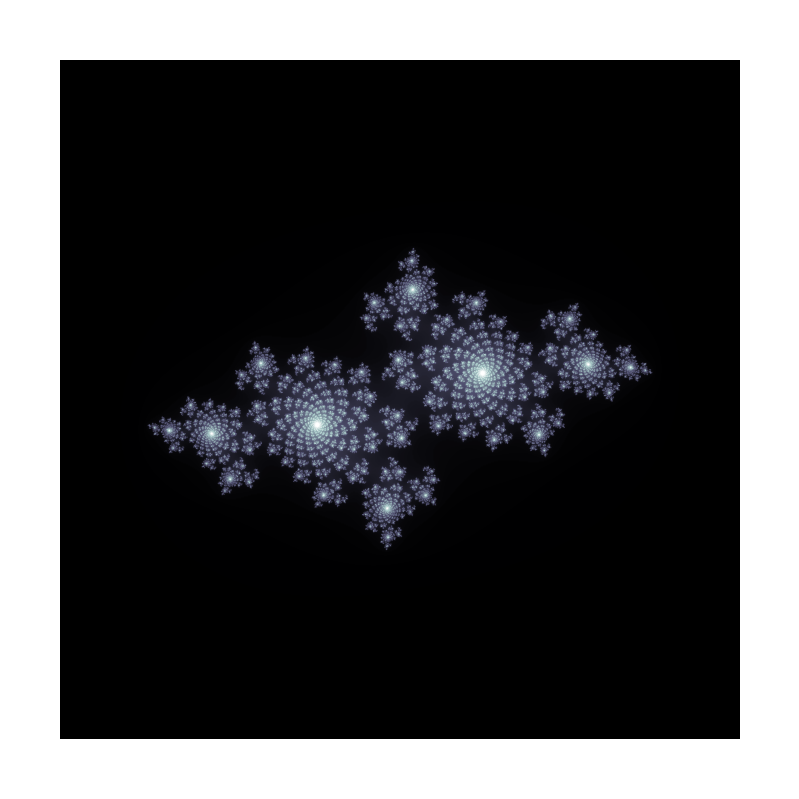

In [25]:
re = np.linspace(-2, 2, 2000)
im = np.linspace(2, -2, 2000)

#実部と虚部の組み合わせを作成
Re, Im = np.meshgrid(re, im)
comp = np.c_[Re.ravel(), Im.ravel()]

#計算結果を格納するための零行列を作成
Julia = np.zeros(len(comp))

s_time = time.time()
#マンデルブロ集合に属するかの計算(ここを並列化)
for i, c_point in enumerate(comp):
    Julia[i] = julia(200, c_point)

e_time = time.time()
print("time: {0:.3f}[s]".format(e_time - s_time))

Julia = Julia.reshape((2000, 2000))

#画像生成
fig = plt.figure(dpi=600)
plt.axis("off")
plt.imshow(Julia, cmap="bone", extent=[-2, 2, -2, 2])
fig.set_size_inches(1.5, 1.5)
plt.show()

#画像を保存
fig.savefig("julia.png")

#並列処理

In [26]:
def make_complex(re, im): #複素数作成
    Re, Im = np.meshgrid(re, im)
    comp = np.c_[Re.ravel(), Im.ravel()]
    return comp

In [27]:
def make_figure(obj): #画像生成
    fig = plt.figure(dpi=600)
    plt.axis("off")
    plt.imshow(obj, cmap="bone", extent=[-2, 2, -2, 2])
    fig.set_size_inches(1.5, 1.5)
    return plt.show()

In [28]:
def check_julia(comp, n_loops=200, threshold=2): #ジュリア集合作成
    """
    c = -0.7 - 0.3i
    """
    re, im = comp[0], comp[1]
    c = complex(-0.7, -0.3)
    z = complex(re, im) #実部がre、虚部がim

    for i in range(n_loops):
        z = z*z + c
        if abs(z) >= threshold:
            return i        
    return n_loops

In [29]:
def sub_check_julia(comp): #ジュリア集合に属するかチェック
  comp_list = []
  for c_point in comp:
    comp_list.append(check_julia(c_point))

  return comp_list

In [30]:
def measure(n_para, separate): #並列化を行う
    re = np.linspace(-2, 2, 2000)
    im = np.linspace(2, -2, 2000)
    comp = make_complex(re, im)

    sep_comp = len(comp) // separate
    result = []
    for y in range(separate):
        result.append(comp[sep_comp * y : sep_comp * (y+1)])

    pool = mp.Pool(n_para)
    s_time = time.time()
    cb = pool.map(sub_check_julia, result)
    e_time = time.time()
    print("time: {0:.3f}[s]".format(e_time - s_time))

    mp_result = []

    for i in cb:
        mp_result.extend(i)

    Julia = np.array(mp_result)

    Julia = Julia.reshape((2000, 2000))
    
    return make_figure(Julia)

time: 13.980[s]


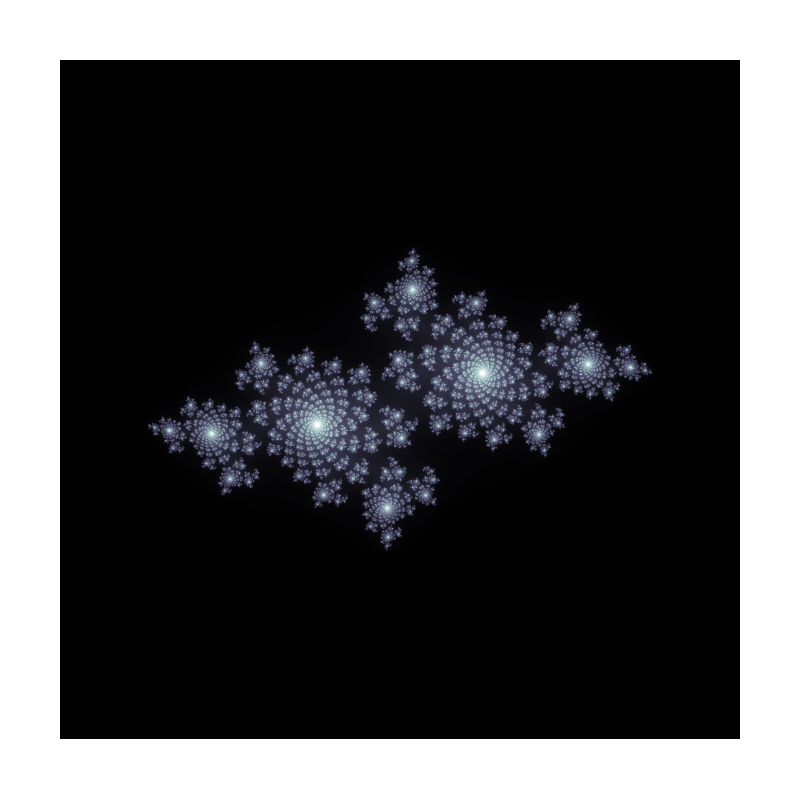

In [31]:
n_para = 8
separate = 10
cb = measure(n_para, separate)